<a href="https://colab.research.google.com/github/zzanggyu/Pill-AI-Notification-System/blob/main/PillColor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python numpy scikit-learn matplotlib ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 52.8 MB/s eta 0:00:00


In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123599 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...



0: 640x640 2 pills, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)


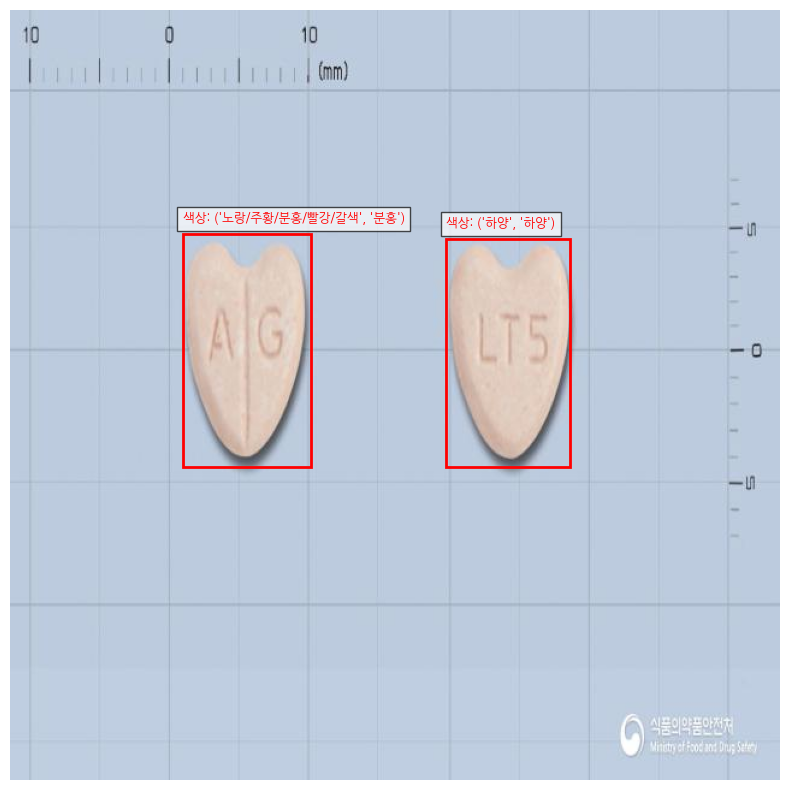

알약 1: bbox=[143.13571166992188, 186.52635192871094, 250.14883422851562, 379.9757080078125], RGB=[222, 201, 188], 색상=('노랑/주황/분홍/빨강/갈색', '분홍')
알약 2: bbox=[362.74029541015625, 190.10006713867188, 465.84283447265625, 379.4468688964844], RGB=[225, 204, 192], 색상=('하양', '하양')


In [ ]:
#### 이걸로 수정

import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from ultralytics import YOLO
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정 (예: 나눔고딕)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 실제 경로로 변경해야 합니다
font_prop = fm.FontProperties(fname=font_path)

# matplotlib 전역 설정
plt.rcParams['font.family'] = font_prop.get_name()

# RGB 값을 한국어 색상 이름으로 매핑하는 딕셔너리
# 색상 그룹을 반영한 딕셔너리
color_groups = {
    '하양': [
        ('하양', (210, 210, 210)),
        ('하양', (220, 220, 220)),
        ('하양', (240, 240, 240))
    ],
    '검정': [
        ('검정', (0, 0, 0)),
        ('검정', (20, 20, 20))
    ],
    '회색': [
        ('회색', (180, 180, 180)),
        ('회색', (128, 128, 128)),
        ('회색', (80, 80, 80))
    ],
    '노랑/주황/분홍/빨강/갈색': [
        ('노랑', (255, 255, 0)),
        ('노랑', (255, 255, 100)),
        ('노랑', (230, 200, 50)),
        ('노랑', (235, 215, 140)),
        ('주황', (255, 165, 0)),
        ('주황', (255, 140, 0)),
        ('주황', (230, 135, 25)),
        ('분홍', (240, 128, 46)),
        ('분홍', (255, 192, 203)),
        ('분홍', (255, 182, 193)),
        ('분홍', (210, 180, 180)),
        ('빨강', (255, 0, 0)),
        ('빨강', (220, 20, 60)),
        # ('갈색', (165, 42, 42)),
        ('갈색', (139, 69, 19)),

    ],
    '연두/초록/청록': [
        ('연두', (154, 205, 50)),
        ('연두', (124, 252, 0)),
        ('연두', (210, 250, 210)),
        ('연두', (192, 217, 197)),
        ('초록', (128, 255, 0)),
        ('초록', (34, 139, 34)),
        ('초록', (60, 150, 60)),
        ('청록', (0, 255, 255)),
        ('청록', (0, 206, 209))
    ],
    '파랑/남색': [
        ('파랑', (135, 206, 235)),
        ('파랑', (100, 149, 237)),
        ('파랑', (0, 0, 255)),
        ('파랑', (30, 144, 255)),
        ('남색', (0, 0, 128)),
        ('남색', (25, 25, 112))
    ],
    '자주/보라': [
        ('자주', (255, 0, 255)),
        ('자주', (218, 112, 214)),
        ('보라', (128, 0, 128)),
        ('보라', (148, 0, 211))
    ]
}

def get_color_distance(color1, color2):
    return sum((a - b) ** 2 for a, b in zip(color1, color2)) ** 0.5

def get_color_name(rgb_color):
    min_distance = float('inf')
    closest_group = '알 수 없음'
    specific_color = '알 수 없음'

    for group_name, colors in color_groups.items():
        for color_name, color in colors:
            distance = get_color_distance(rgb_color, color)
            if distance < min_distance:
                min_distance = distance
                closest_group = group_name
                specific_color = color_name

    return closest_group, specific_color

def extract_pill_color(image, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    pill_image = image[y1:y2, x1:x2]

    rgb_image = cv2.cvtColor(pill_image, cv2.COLOR_BGR2RGB)
    lab_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2LAB)
    pixels = lab_image.reshape(-1, 3)

    kmeans = KMeans(n_clusters=3, n_init=10)
    kmeans.fit(pixels)

    colors = kmeans.cluster_centers_
    colors = colors.astype(int)
    colors = [cv2.cvtColor(color.reshape(1, 1, 3).astype(np.uint8), cv2.COLOR_LAB2RGB)[0][0] for color in colors]

    counts = np.bincount(kmeans.labels_)
    dominant_color = colors[np.argmax(counts)]

    color_name = get_color_name(dominant_color)
    return dominant_color.tolist(), color_name

def detect_pills(image, model):
    results = model(image)
    return results[0].boxes.xyxy.cpu().numpy()

def visualize_results(image, bboxes, colors, color_names):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(rgb_image)

    for bbox, color, name in zip(bboxes, colors, color_names):
        x1, y1, x2, y2 = map(int, bbox)
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
        plt.gca().text(x1, y1-10, f'색상: {name}', color='red', fontsize=9, bbox=dict(facecolor='white', alpha=0.7),
                       fontproperties=font_prop)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 메인 실행 코드
if __name__ == "__main__":
    model = YOLO('/content/drive/MyDrive/best.pt')  # YOLO 모델 경로를 지정해주세요

    image_path = '/content/drive/MyDrive/testimg/-5-2-5-_jpg.rf.1fd92d24f74bc35ffec1261602255ed1.jpg'  # 테스트할 이미지 경로를 지정해주세요
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Failed to load image from {image_path}")

    bboxes = detect_pills(image, model)

    colors_and_names = [extract_pill_color(image, bbox) for bbox in bboxes]
    colors, color_names = zip(*colors_and_names)

    visualize_results(image, bboxes, colors, color_names)

    for i, (bbox, color, name) in enumerate(zip(bboxes, colors, color_names), 1):
        print(f"알약 {i}: bbox={bbox.tolist()}, RGB={color}, 색상={name}")